In [1]:
from datasets import load_dataset

In [2]:
open_greek = load_dataset("parquet", data_files="../data/*.parquet")
open_greek = open_greek['train'].train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
open_greek

DatasetDict({
    train: Dataset({
        features: ['group', 'book', 'text', 'locs', 'batch', 'author', 'date', 'period', 'duplicate', 'book_title', 'book_author', 'ocr_score_src'],
        num_rows: 6492
    })
    test: Dataset({
        features: ['group', 'book', 'text', 'locs', 'batch', 'author', 'date', 'period', 'duplicate', 'book_title', 'book_author', 'ocr_score_src'],
        num_rows: 1623
    })
})

In [4]:
open_greek['train'].to_pandas()['date'].value_counts()

date
500 BCE            921
500 BCE-400 BCE    678
200 CE             487
400 BCE            405
100 CE             271
                  ... 
1825                 1
600 BCE-50 BCE       1
1730                 1
400 BCE/300 BCE      1
1350                 1
Name: count, Length: 175, dtype: int64

In [5]:
import os
from bs4 import BeautifulSoup

greek_texts = {}

for path, directories, files in os.walk("/cluster/tufts/tuftsai/datasets/greek_data/greek_texts"):
    for file in files:
        if file.endswith(".xml") and ('grc' in file):
            with open(os.path.join(path, file), "r") as f:
                soup = BeautifulSoup(f.read())
                greek_texts[file] = soup.get_text().strip()

len(greek_texts)

814

In [6]:
from datasets import Dataset, DatasetDict, concatenate_datasets
from sklearn.model_selection import train_test_split

merged_dataset = concatenate_datasets([open_greek['train'], open_greek['test']])
texts = list(greek_texts.values())
ids = list(greek_texts.keys())

new_dataset = Dataset.from_dict({
    'id': ids,
    'text': texts
})
combined_dataset = concatenate_datasets([merged_dataset, new_dataset])
data_dict = combined_dataset.to_dict()

indices = list(range(len(combined_dataset)))
train_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2,  
    random_state=42, 
    shuffle=True
)

train_dataset = combined_dataset.select(train_indices)
test_dataset = combined_dataset.select(test_indices)

new_dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(f"Train size: {len(new_dataset_dict['train'])}")
print(f"Test size: {len(new_dataset_dict['test'])}")

Train size: 7143
Test size: 1786


In [7]:
from transformers import TrainingArguments, Trainer, AutoConfig, AutoTokenizer, AutoModelForMaskedLM

# config = AutoConfig.from_pretrained("answerdotai/ModernBERT-base")
# tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1") # for finetuning
# model = AutoModelForMaskedLM.from_config(config).to("cuda")

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


In [8]:
tokenizer.eos_token = tokenizer.pad_token

In [7]:
# trained tokenizer on test set
# from tqdm import tqdm

# new_tokenizer_id = "modernbert-greek-tokenizer"
# def batch_iterator(batch_size=10000):
#     for i in tqdm(range(0, len(open_greek['test']), batch_size)):
#         yield open_greek['test'][i : i + batch_size]["text"] 
# bert_tokenizer = tokenizer.train_new_from_iterator(text_iterator=batch_iterator(), vocab_size=50_368)
# bert_tokenizer.save_pretrained(new_tokenizer_id)

In [9]:
test_tokenization = tokenizer(open_greek['train']['text'][0:2], truncation=False)
[len(ii) for ii in test_tokenization['input_ids']]

[29307, 1983]

In [10]:
chunk_size = 1024
test_input_ids = []
test_attention_masks = []
test_labels = []

for input_ids in test_tokenization["input_ids"]:
    length = len(input_ids)
    for i in range(0, length, chunk_size-2):
        end = min(i + chunk_size - 2, length)
        chunk_ids = input_ids[i:end]
        bert_input_ids = [tokenizer.cls_token_id] + chunk_ids + [tokenizer.sep_token_id]
        bert_attention_mask = [1] * len(bert_input_ids)
        if len(bert_input_ids) < chunk_size:
            padding_length = chunk_size - len(bert_input_ids)
            bert_input_ids += [tokenizer.pad_token_id] * padding_length
            bert_attention_mask += [0] * padding_length
        labels = bert_input_ids.copy()
        test_input_ids.append(bert_input_ids)
        test_attention_masks.append(bert_attention_mask)
        test_labels.append(labels)

In [11]:
[len(ii) for ii in test_input_ids][:5] # looks good

[1024, 1024, 1024, 1024, 1024]

In [12]:
from tqdm import tqdm
from datasets import Dataset

# takes about 10 min
def tokenize_and_prepare_mlm(examples, chunk_size=512, ignore_length=8):
    tokenized = tokenizer(examples["text"], truncation=False)

    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for input_ids in tqdm(tokenized["input_ids"], total=len(tokenized["input_ids"])):
        length = len(input_ids)
        if length < ignore_length:
            continue
        
        for i in range(0, length, chunk_size-2): # accounting for special tokens
            end = min(i + chunk_size - 2, length)
            chunk_ids = input_ids[i:end]
            bert_input_ids = [tokenizer.cls_token_id] + chunk_ids + [tokenizer.sep_token_id]
            bert_attention_mask = [1] * len(bert_input_ids)
            if len(bert_input_ids) < chunk_size:
                padding_length = chunk_size - len(bert_input_ids)
                bert_input_ids += [tokenizer.pad_token_id] * padding_length
                bert_attention_mask += [0] * padding_length
            labels = bert_input_ids.copy()
            all_input_ids.append(bert_input_ids)
            all_attention_masks.append(bert_attention_mask)
            all_labels.append(labels)
    return {"input_ids": all_input_ids, "attention_mask": all_attention_masks, "labels": all_labels}

tokenized_datasets = Dataset.from_dict(tokenize_and_prepare_mlm(open_greek['train'])).train_test_split(test_size=0.2)
tokenized_datasets.set_format(type="torch")

100%|██████████| 6492/6492 [03:28<00:00, 31.09it/s] 


In [13]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1374466
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 343617
    })
})

In [14]:
tokenized_datasets.save_to_disk("../data/nlpaueb_tokenized_open_greek_dataset")

Saving the dataset (0/19 shards):   0%|          | 0/1374466 [00:00<?, ? examples/s]

Saving the dataset (0/5 shards):   0%|          | 0/343617 [00:00<?, ? examples/s]

In [7]:
model_name = "answerdotai/ModernBERT-base"
config = AutoConfig.from_pretrained(model_name)

In [8]:
vocab_size = len(tokenizer.get_vocab())
config.vocab_size = vocab_size
config.bos_token_id = tokenizer.bos_token_id
config.eos_token_id = tokenizer.eos_token_id
config.pad_token_id = tokenizer.pad_token_id
config.cls_token_id = tokenizer.cls_token_id
config.sep_token_id = tokenizer.sep_token_id

In [9]:
model = AutoModelForMaskedLM.from_config(config)
sum(p.numel() for p in model.parameters())/1e6

149.655232

In [10]:
device = "cuda"
model = model.to(device)

In [11]:
tokenized_datasets['train'][0]['input_ids']

tensor([    3, 11301,  7439,  ..., 41799,  7739,     4])

In [ ]:
test_input_ids = tokenized_datasets['train'][0]['input_ids'].clone()
test_labels = tokenized_datasets['train'][0]['labels'].clone()
test_attention_mask = tokenized_datasets['train'][0]['attention_mask'].clone()

In [12]:
import torch
import numpy as np
# https://github.com/AnswerDotAI/ModernBERT/blob/main/src/sequence_packer.py
mask_prob = 0.3
mask_token = tokenizer.mask_token_id
pad_token = tokenizer.pad_token_id
ignore_index = -100
np_rng = np.random.default_rng()

In [ ]:
seq = test_input_ids.cpu().numpy()
labels = np.where(seq == pad_token, ignore_index, seq)
rand = np_rng.random(seq.shape)

In [ ]:
# Partition the probability space appropriately using a single mask
# 80% of the time, we mask the token
mask_mask = rand < mask_prob * 0.8
# 10% of the time, we replace the token with a random token
random_mask = (rand >= mask_prob * 0.8) & (rand < mask_prob * 0.9)
# 10% of the time, we keep the token the same
keep_mask = (rand >= mask_prob * 0.9) & (rand < mask_prob)

In [ ]:
# We only compute loss over the tokens marked for masking
labels = np.where(mask_mask | random_mask | keep_mask, labels, ignore_index)

In [ ]:
# Apply masking
seq = np.where(mask_mask, mask_token, seq)

In [ ]:
random_words = np_rng.integers(0, np.max(seq) + 1, size=seq.shape)

In [ ]:
seq = np.where(random_mask, random_words, seq)

In [ ]:
seq, labels

(array([    3,   476, 47920, ...,    18,   335,     4], shape=(1024,)),
 array([-100, -100, -100, ..., -100, -100, -100], shape=(1024,)))

In [13]:
def mlm_masking(input_ids, mask_prob=0.3, mask_token=None, pad_token=None, ignore_index=-100):
    seq = input_ids.cpu().numpy()
    labels = np.where(seq == pad_token, ignore_index, seq)
    rand = np_rng.random(seq.shape)

    # Partition the probability space appropriately using a single mask
    # 80% of the time, we mask the token
    mask_mask = rand < mask_prob * 0.8
    # 10% of the time, we replace the token with a random token
    random_mask = (rand >= mask_prob * 0.8) & (rand < mask_prob * 0.9)
    # 10% of the time, we keep the token the same
    keep_mask = (rand >= mask_prob * 0.9) & (rand < mask_prob)

    # We only compute loss over the tokens marked for masking
    labels = np.where(mask_mask | random_mask | keep_mask, labels, ignore_index)

    # Apply masking
    seq = np.where(mask_mask, mask_token, seq)

    random_words = np_rng.integers(0, np.max(seq) + 1, size=seq.shape)

    seq = np.where(random_mask, random_words, seq)

    return torch.tensor(seq), torch.tensor(labels)

In [ ]:
tokenized_datasets['train'][0:2]['input_ids'].clone()

tensor([[    3,   476, 47920,  ...,    18,   335,     4],
        [    3,  1482,   361,  ..., 32459, 27503,     4]])

In [ ]:
batch_seq, batch_labels = mlm_masking(tokenized_datasets['train'][0:5]['input_ids'].clone(), mask_prob, mask_token, pad_token, ignore_index)
batch_seq.shape, batch_labels.shape

(torch.Size([5, 1024]), torch.Size([5, 1024]))

In [14]:
from torch.utils.data import DataLoader
batch_size = 32

train_dataloader = DataLoader(
    tokenized_datasets["train"], 
    batch_size=batch_size,
    shuffle=False 
)
valid_dataloader = DataLoader(
    tokenized_datasets["test"], 
    batch_size=batch_size,
    shuffle=False 
)

In [15]:
import torch
lr = 3e-4
weight_decay = 0.01

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr,
    weight_decay=weight_decay
)

In [ ]:
num_epochs = 5 # just to test
max_lr = 1e-3
pct_start = 0.05

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=max_lr,
    pct_start=pct_start,
    total_steps=num_training_steps
)

In [17]:
model = model.to(device)

In [ ]:
losses = []
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        # mlm
        masked_input_ids, masked_labels = mlm_masking(input_ids, mask_prob, mask_token, pad_token, ignore_index)
        masked_input_ids = masked_input_ids.to(device)
        masked_labels = masked_labels.to(device)

        outputs = model(input_ids=masked_input_ids, attention_mask=attention_mask, labels=masked_labels)
        loss = outputs.loss
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

Epoch 0


KeyboardInterrupt: 

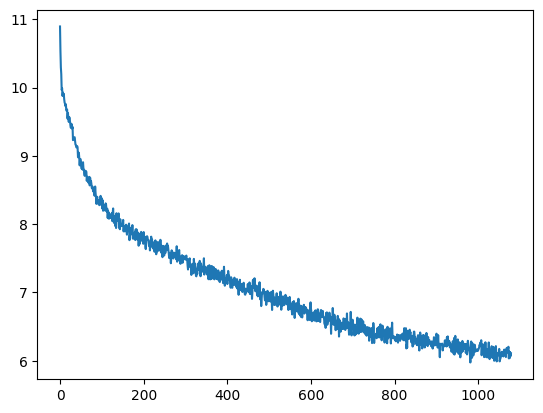

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)